# Análisis de datos genéticos de cáncer de seno
## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import re

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer


import seaborn as sns
from sklearn import metrics

## Carga de datos

In [2]:
df = pd.read_csv('METABRIC_RNA_MUTATION.csv')

C:\Users\achav\AppData\Local\Temp\ipykernel_7532\1524619863.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('METABRIC_RNA_MUTATION.csv')


## Encabezado de la tabla

In [3]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


## Forma y columnas de los datos

In [4]:
print(df.shape)
print(df.columns)

(1904, 693)
Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=693)


## Tipos de datos de cada columna

In [5]:
df.dtypes

patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object

## Algunas columnas muestran una alerta de diferentes tipos de datos

In [6]:
df.columns.values[[678, 688, 690, 692]]

array(['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut'],
      dtype=object)

In [7]:
df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']].dtypes

rasgef1b_mut    object
hras_mut        object
smarcb1_mut     object
siah1_mut       object
dtype: object

## Descripcion de las variables con la alerta

In [8]:
df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']].describe()

,rasgef1b_mut,hras_mut,smarcb1_mut,siah1_mut
count,1904,1904,1904,1904
unique,9,4,4,3
top,0,0,0,0
freq,1024,1024,1024,1024


## Las variables con la alerta indican mutaciones en los genes correspondientes. 0 = no mutacion ; x = mutacion hay valores de 0 como caracter. Estas columnas habrá que binarizarlas.

In [9]:
print(df['rasgef1b_mut'].unique())
print(df['hras_mut'].unique())
print(df['smarcb1_mut'].unique())
print(df['siah1_mut'].unique())

[0 '0' 'V418A' 'S343G' 'R140Q' 'X2_splice' 'R353H' 'H396Y' 'E78K']
[0 '0' 'Q61R' 'N86T']
[0 '0' 'D159N' 'I28L']
[0 '0' 'T249A']


## Empezamos haciendo la conversión de '0' a 0 para todas las columnas donde había ambigüedad

In [10]:
df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']] = df[['rasgef1b_mut', 'hras_mut', 'smarcb1_mut', 'siah1_mut']].replace(['0'], 0)

In [11]:
print(df['rasgef1b_mut'].unique())
print(df['hras_mut'].unique())
print(df['smarcb1_mut'].unique())
print(df['siah1_mut'].unique())

[0 'V418A' 'S343G' 'R140Q' 'X2_splice' 'R353H' 'H396Y' 'E78K']
[0 'Q61R' 'N86T']
[0 'D159N' 'I28L']
[0 'T249A']


## Algoritmo de binarización aplicado a mutaciones

In [12]:
for mut in df['rasgef1b_mut'].unique():
    if mut != 0:
        column = df['rasgef1b_mut'] == mut
        column = column.replace([False], 0).replace([True],1)
        df[mut] = column

## Histograma de edad de diagnóstico

(array([ 10.,  54., 159., 265., 315., 389., 379., 237.,  86.,  10.]),
 array([21.93 , 29.366, 36.802, 44.238, 51.674, 59.11 , 66.546, 73.982,
        81.418, 88.854, 96.29 ]),
 <BarContainer object of 10 artists>)

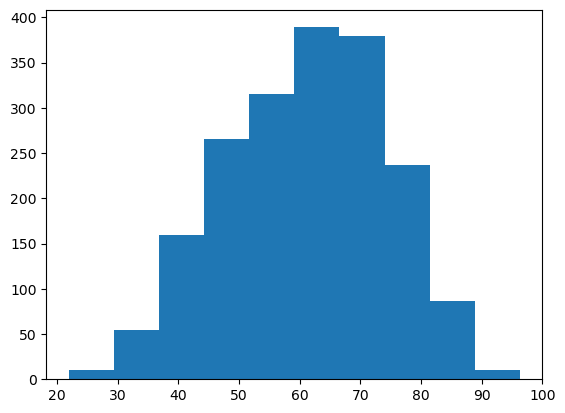

In [13]:
plt.hist(df['age_at_diagnosis'])

## Descripción de edad de diagnóstico

In [14]:
df['age_at_diagnosis'].describe()

count    1904.000000
mean       61.087054
std        12.978711
min        21.930000
25%        51.375000
50%        61.770000
75%        70.592500
max        96.290000
Name: age_at_diagnosis, dtype: float64

## Conteo de valores de las variables no genéticas

In [15]:
for i in range(2,31):
    print(i, df.columns[i])
    value_counts = df.iloc[:,i].value_counts()
    nan = df.iloc[:,i].isna().sum()
    print(value_counts)
    print('nans:',nan, '\n')

2 type_of_breast_surgery
MASTECTOMY           1127
BREAST CONSERVING     755
Name: type_of_breast_surgery, dtype: int64
nans: 22 

3 cancer_type
Breast Cancer     1903
Breast Sarcoma       1
Name: cancer_type, dtype: int64
nans: 0 

4 cancer_type_detailed
Breast Invasive Ductal Carcinoma             1500
Breast Mixed Ductal and Lobular Carcinoma     207
Breast Invasive Lobular Carcinoma             142
Breast Invasive Mixed Mucinous Carcinoma       22
Breast                                         17
Metaplastic Breast Cancer                       1
Name: cancer_type_detailed, dtype: int64
nans: 15 

5 cellularity
High        939
Moderate    711
Low         200
Name: cellularity, dtype: int64
nans: 54 

6 chemotherapy
0    1508
1     396
Name: chemotherapy, dtype: int64
nans: 0 

7 pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: pam50_+_claudin-low_subtype, dtype: int6

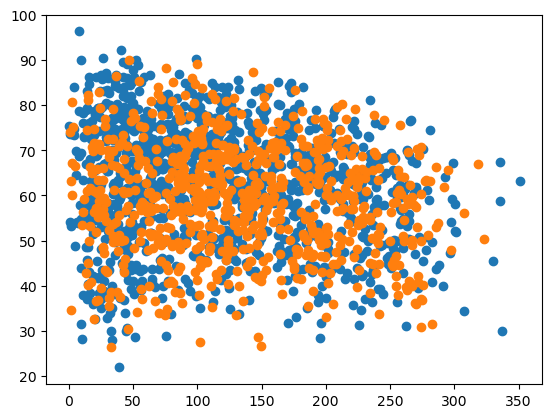

In [16]:
x1 = df.overall_survival_months[df.type_of_breast_surgery == 'MASTECTOMY']
y1 = df.age_at_diagnosis[df.type_of_breast_surgery == 'MASTECTOMY']

x2 = df.overall_survival_months[df.type_of_breast_surgery == 'BREAST CONSERVING']
y2 = df.age_at_diagnosis[df.type_of_breast_surgery == 'BREAST CONSERVING']

plt.scatter(x1, y1)
plt.scatter(x2, y2)

## Seleccionando los datos de entrenamiento y prueba

In [172]:
train_dataset = df.dropna().sample(frac=0.75, random_state=1)
test_dataset = df.drop(train_dataset.index).dropna()

x_train, y_train = train_dataset.loc[:,'brca1':'ugt2b7'], train_dataset['overall_survival']
x_test, y_test = test_dataset.loc[:,'brca1':'ugt2b7'], test_dataset['overall_survival']


In [173]:
print(test_dataset['cancer_type_detailed'].unique())
y_train = pd.get_dummies(train_dataset['cancer_type_detailed'])
y_test = pd.get_dummies(test_dataset['cancer_type_detailed'])


['Breast Invasive Lobular Carcinoma' 'Breast Invasive Ductal Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma' 'Breast']


In [174]:
print(len(train_dataset))
print(len(test_dataset))

819
273


In [175]:
max_iter = 100
log_reg = LogisticRegression(multi_class='multinomial', max_iter=max_iter)
x_train = train_dataset.loc[:,'brca1':'gdf2']
x_test = test_dataset.loc[:,'brca1':'gdf2']

for cancer_type in test_dataset['cancer_type_detailed'].dropna().unique():
    print(cancer_type)
    print(y_test[cancer_type].value_counts())
    log_reg.fit(x_train, y_train[cancer_type])
    predictions = log_reg.predict(x_test)
    score = log_reg.score(x_test, y_test[cancer_type])
    print(score)
    cm = metrics.confusion_matrix(y_test[cancer_type], predictions)
    print(cm)


Breast Invasive Lobular Carcinoma
0    255
1     18
Name: Breast Invasive Lobular Carcinoma, dtype: int64
0.8827838827838828
[[238  17]
 [ 15   3]]
Breast Invasive Ductal Carcinoma
1    214
0     59
Name: Breast Invasive Ductal Carcinoma, dtype: int64
0.73992673992674
[[ 16  43]
 [ 28 186]]
Breast Mixed Ductal and Lobular Carcinoma
0    238
1     35
Name: Breast Mixed Ductal and Lobular Carcinoma, dtype: int64
0.8278388278388278
[[217  21]
 [ 26   9]]
Breast Invasive Mixed Mucinous Carcinoma
0    269
1      4
Name: Breast Invasive Mixed Mucinous Carcinoma, dtype: int64
0.9816849816849816
[[268   1]
 [  4   0]]
Breast
0    271
1      2
Name: Breast, dtype: int64
0.9926739926739927
[[271   0]
 [  2   0]]


C:\Users\achav\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [176]:
for cancer_type in test_dataset['cancer_type_detailed'].dropna().unique():
    print(cancer_type)
    print(y_train[cancer_type].value_counts())
    log_reg.fit(x_train, y_train[cancer_type])
    predictions = log_reg.predict(x_test)
    score = log_reg.score(x_test, y_test[cancer_type])
    print(score)
    cm = metrics.confusion_matrix(y_test[cancer_type], predictions)
    print(cm)

Breast Invasive Lobular Carcinoma
0    760
1     59
Name: Breast Invasive Lobular Carcinoma, dtype: int64
0.8827838827838828
[[238  17]
 [ 15   3]]
Breast Invasive Ductal Carcinoma
1    645
0    174
Name: Breast Invasive Ductal Carcinoma, dtype: int64
0.73992673992674
[[ 16  43]
 [ 28 186]]
Breast Mixed Ductal and Lobular Carcinoma
0    716
1    103
Name: Breast Mixed Ductal and Lobular Carcinoma, dtype: int64


C:\Users\achav\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8278388278388278
[[217  21]
 [ 26   9]]
Breast Invasive Mixed Mucinous Carcinoma
0    810
1      9
Name: Breast Invasive Mixed Mucinous Carcinoma, dtype: int64
0.9816849816849816
[[268   1]
 [  4   0]]
Breast
0    816
1      3
Name: Breast, dtype: int64
0.9926739926739927
[[271   0]
 [  2   0]]


In [177]:
cm = metrics.confusion_matrix(y_test['Breast Invasive Ductal Carcinoma'], predictions)
print(cm)

[[ 59   0]
 [214   0]]


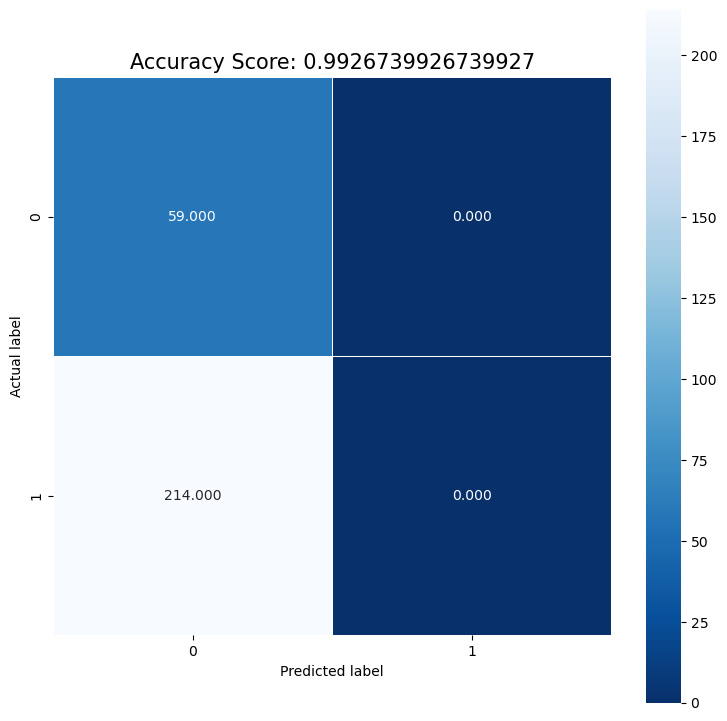

In [178]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [106]:
from sklearn.neural_network import MLPClassifier

In [182]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-3, random_state=1)
model = clf.fit(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(clf.score(x_test,y_test))
predictions = clf.predict(x_test[:1])
cm = metrics.confusion_matrix(y_test, predictions)


(819, 169) (819, 5)
(273, 169) (273, 5)
0.6593406593406593


ValueError: Found input variables with inconsistent numbers of samples: [273, 1]